In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(420)
N = 500

In [2]:
def genSOAR(length, p, a):
    ex = np.random.randn(length)

    S = ex.copy();
    for n in range(2, length):
        x = np.array([S[n-1], S[n-2]])
        S[n] = np.dot(x, a) + ex[n]
        
    return S, a, ex

Text(0.5, 1.0, 'Autoregressive Process')

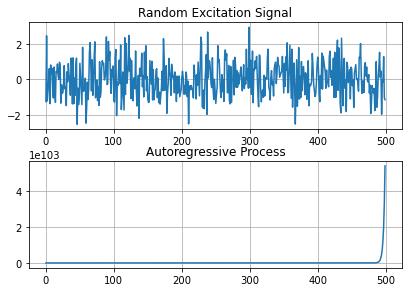

In [46]:
S, a, ex = genSOAR(500, 2, [1,1])

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6,4))
plt.tight_layout()
ax[0].plot(range(500), ex)
ax[0].grid(True)
ax[0].set_title("Random Excitation Signal")
ax[1].plot(range(500), S)
ax[1].grid(True)
ax[1].set_title("Autoregressive Process")


In [3]:
def genTVSOAR(length, p, a0):
    ex = np.random.randn(length)

    A = np.zeros((N, p))
    omega, alpha = N/2, 0.1

    for n in range(N):
        A[n,0] = a0[0] + alpha * np.cos(2*np.pi*n/N)
        A[n,1] = a0[1] + alpha * 1.4*np.sin(6*np.pi*n/N)
    #implement new order here

    S = ex.copy();
    for n in range(p, N):
        x = np.array(S[slice(n-1, n-1-p if(n-1-p>=0) else None,-1)])
        S[n] = np.dot(x, A[n,:]) + ex[n]
        
    return S, A, ex

Text(0.5, 1.0, 'Time Varying Autoregressive Process')

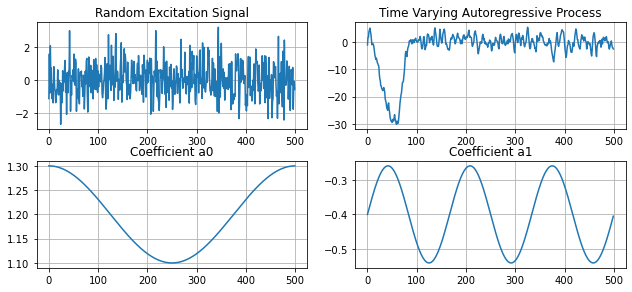

In [160]:
N = 500
a0 = np.array([1.2, -0.4])
S2, A, ex = genTVSOAR(500, 2, a0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,4))
plt.tight_layout()
ax[1,0].plot(range(N), A[:,0])
ax[1,0].grid(True)
ax[1,0].set_title("Coefficient a0")
ax[1,1].plot(range(N), A[:,1])
ax[1,1].grid(True)
ax[1,1].set_title("Coefficient a1")
ax[0,0].plot(range(N), ex)
ax[0,0].grid(True)
ax[0,0].set_title("Random Excitation Signal")
ax[0,1].plot(range(N), S2)
ax[0,1].grid(True)
ax[0,1].set_title("Time Varying Autoregressive Process")


In [4]:
import numpy as np

class KalFilt:
       
    covLog = np.zeros([2,N])
    n=1
    
    def __init__(self, ps, R, eps, Qeps, th):
        self.theta = th
        self.psize = ps
        self.P = eps * np.identity(ps) 
        self.Q = Qeps * np.identity(ps) 
        self.R = R
        
        self.covLog[0,0] = self.theta[0].copy()
        self.covLog[1,0] = self.theta[1].copy()

        self.covLog[0,1] = self.theta[0].copy()
        self.covLog[1,1] = self.theta[1].copy()
    
    def predict_state(self):
        self.Pn1n1 = self.P.copy()
        self.P = self.P + self.Q
    
    def predict_point(self, x):
        return self.theta.T @ x
    
    def predict(self, x):
        self.predict_state()
        y = self.predict_point(x)
        return y
        
    def update(self, x, y):
        error = y - self.theta.T @ x
        k = (self.P @ x) / (R + x.T @ self.P @ x)
        
        self.theta += k * error
        self.P = (np.identity(self.psize) - k @ x.T) @ self.P
        
        self.n+=1
        self.covLog[0,n] = self.theta[0].copy()
        self.covLog[1,n] = self.theta[1].copy()
        
        return error

# Iinitial conditions

[ 0.7 -0.4]

[ 0.64959143 -0.41465016]
[ 0.64151635 -0.15876098]
[ 0.99234932 -2.10344617]
[-1.47720404 -0.53746299]
[-1.9091861  -0.22646304]


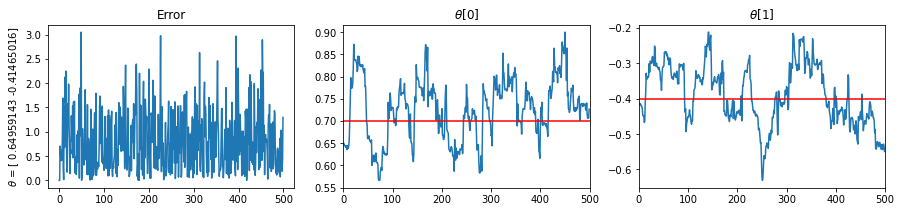

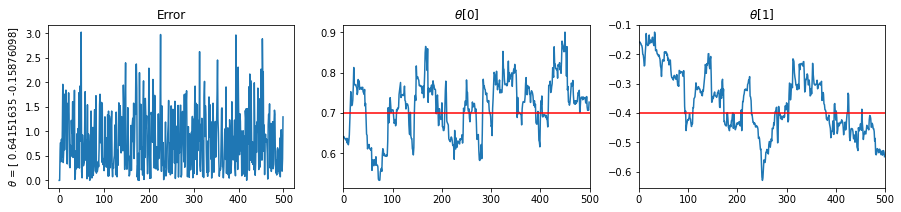

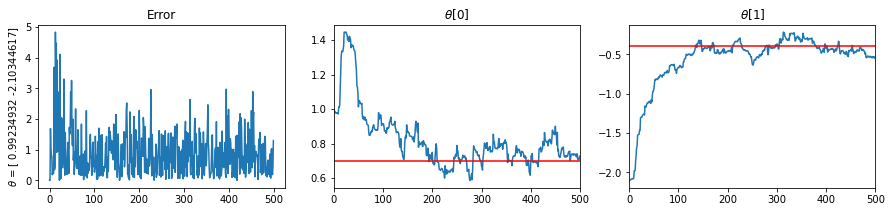

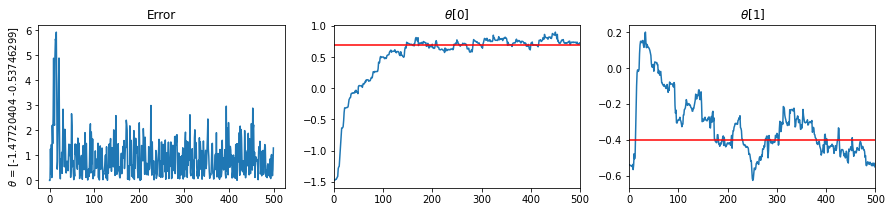

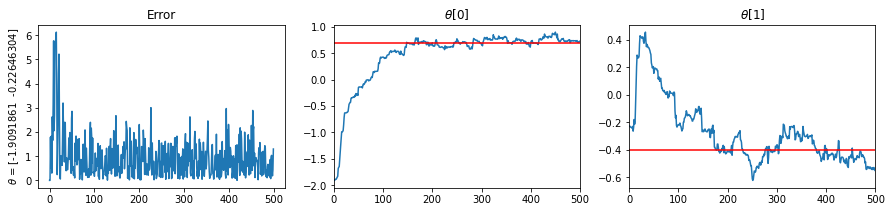

In [75]:
def rofc(x, n):
    num = np.log(np.linalg.norm((x[n+1]-x[n])/(x[n]-x[n-1])))
    den = np.log(np.linalg.norm((x[n]-x[n-1])/(x[n-1]-x[n-2])))
    return num/den

a0 = np.array([0.7, -0.4])
print(a0)
print()
N = 500
S, a, ex = genSOAR(N, 2, a0)

#KF parameters and initialisation
R = 0.2*np.std(ex[0:10])
eps = 0.001
Qeps = 0.0001

EPlot = np.empty([5,N])
PredsPlot = np.empty([5,N])
thetaTrack = np.array([[ 0.64959143, -0.41465016],
                       [ 0.64151635, -0.15876098],
                       [ 0.99234932, -2.10344617],
                       [-1.47720404, -0.53746299],
                       [-1.9091861,  -0.22646304]])
covlogA0 = np.empty([5,N])
covlogA1 = np.empty([5,N])
for l in range(5):
    theta = thetaTrack[l].copy()
    print(theta)
    thetaTrack[l] = theta.copy()
    theta = theta.reshape(-1,1)
    kf = KalFilt(2, R, eps, Qeps, theta)

    #initialise var tracking
    preds = np.zeros(N)
    es = np.zeros(N)
    x = np.zeros((2,1))

    #run KF on S
    for n in range(2, N):
        x[0] = S[n-1]
        x[1] = S[n-2]
    
        preds[n] = kf.predict(x)
        es[n] = np.linalg.norm(kf.update(x, S[n]))
    EPlot[l] = es.copy()
    PredsPlot[l] = preds.copy()
    covlogA0[l] = kf.covLog[0].copy()
    covlogA1[l] = kf.covLog[1].copy()
    
for m in range(5):
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,3))
    ax[0].plot(EPlot[m])
    ax[0].set_title("Error")
    ax[0].set_ylabel("$\\theta$ = "+str(thetaTrack[m]))

    ax[1].plot(covlogA0[m])
    ax[1].axhline(a[0],color='r')
    ax[1].set_xlim(0,500)
    ax[1].set_title("$\\theta$[0]")

    ax[2].plot(covlogA1[m])
    ax[2].axhline(a[1],color='r')
    ax[2].set_xlim(0,500)
    ax[2].set_title("$\\theta$[1]")

# Process noise covariance

[ 0.7 -0.4]
Error:  1.3272600028007924


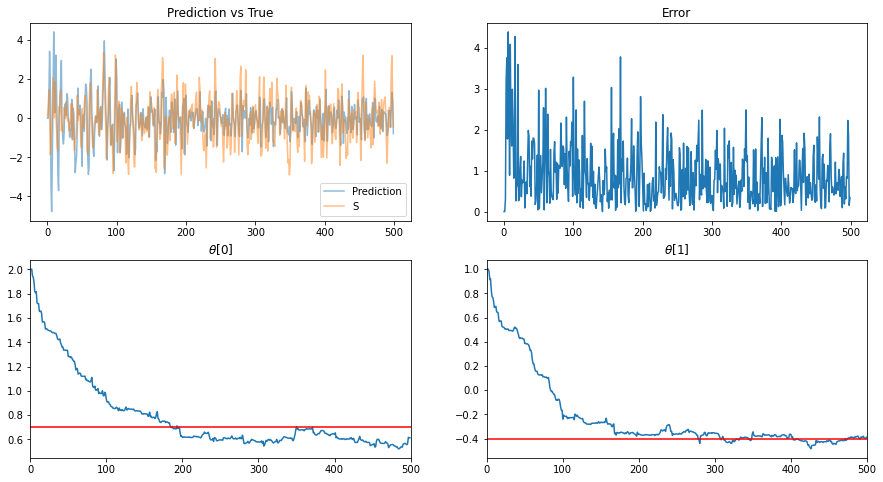

In [49]:
mag = 0.1
#KF parameters and initialisation
theta = np.array([2.0, 1.0])
theta = theta.reshape(-1,1)
R = mag*np.std(ex[0:10])
eps = 0.001
epsscale = 0.00001 ## Change this to alter Q (eps/epsscale * I )
kf = KalFilt(2, R, eps, epsscale, theta)

#initialise var tracking
preds = np.zeros(N)
es = np.zeros(N)
x = np.zeros((2,1))

#run KF on S
for n in range(2, N):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    preds[n] = kf.predict(x)
    es[n] = np.linalg.norm(kf.update(x, S[n]))
    
#plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
ax[0,0].plot(preds, label='Prediction',alpha=0.5)
ax[0,0].plot(S, label='S', alpha=0.5)
ax[0,0].set_title("Prediction vs True")
ax[0,0].legend()
ax[0,1].plot(es)
ax[0,1].set_title("Error")

ax[1,0].plot(kf.covLog[0])
#ax[1,0].plot(A[:,0])
ax[1,0].axhline(a[0],color='r')
ax[1,0].set_xlim(0,500)
ax[1,0].set_title("$\\theta$[0]")

ax[1,1].plot(kf.covLog[1])
#ax[1,1].plot(A[:,1])
ax[1,1].axhline(a[1],color='r')
ax[1,1].set_xlim(0,500)
ax[1,1].set_title("$\\theta$[1]")

savestr = "Q-"+str(epsscale)+".png"
fig.savefig(savestr)

print(a)
print("Error: ", (es**2).mean(axis=0))

In [33]:
a0 = np.array([0.7, -0.4])

S, a, ex = genSOAR(500, 2, a0)

# Measurment noise variance

[ 0.7 -0.4]
Error:  1.1683237186221622


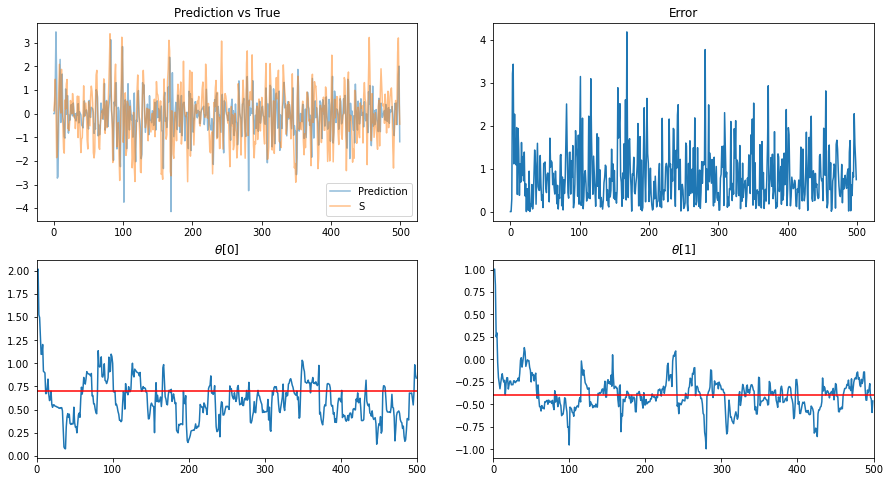

In [52]:
#initial conditions AR generation


mag = 0.01 ## Change this to alter R
#KF parameters and initialisation
theta = np.array([2.0, 1.0])
theta = theta.reshape(-1,1)
R = mag*np.std(ex[0:10]) 
eps = 0.001
epsscale = 0.0001
kf = KalFilt(2, R, eps, epsscale, theta)

#initialise var tracking
preds = np.zeros(N)
es = np.zeros(N)
x = np.zeros((2,1))

#run KF on S
for n in range(2, N):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    preds[n] = kf.predict(x)
    es[n] = np.linalg.norm(kf.update(x, S[n]))
    
#plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
ax[0,0].plot(preds, label='Prediction',alpha=0.5)
ax[0,0].plot(S, label='S', alpha=0.5)
ax[0,0].set_title("Prediction vs True")
ax[0,0].legend()
ax[0,1].plot(es)
ax[0,1].set_title("Error")

ax[1,0].plot(kf.covLog[0])
#ax[1,0].plot(A[:,0])
ax[1,0].axhline(a[0],color='r')
ax[1,0].set_xlim(0,500)
ax[1,0].set_title("$\\theta$[0]")

ax[1,1].plot(kf.covLog[1])
#ax[1,1].plot(A[:,1])
ax[1,1].axhline(a[1],color='r')
ax[1,1].set_xlim(0,500)
ax[1,1].set_title("$\\theta$[1]")

savestr = "R-"+str(mag)+".png"
fig.savefig(savestr)

print(a)
print("Error: ", (es**2).mean(axis=0))

# Constant vs Time Varying AR

Error:  1.2003283968342546


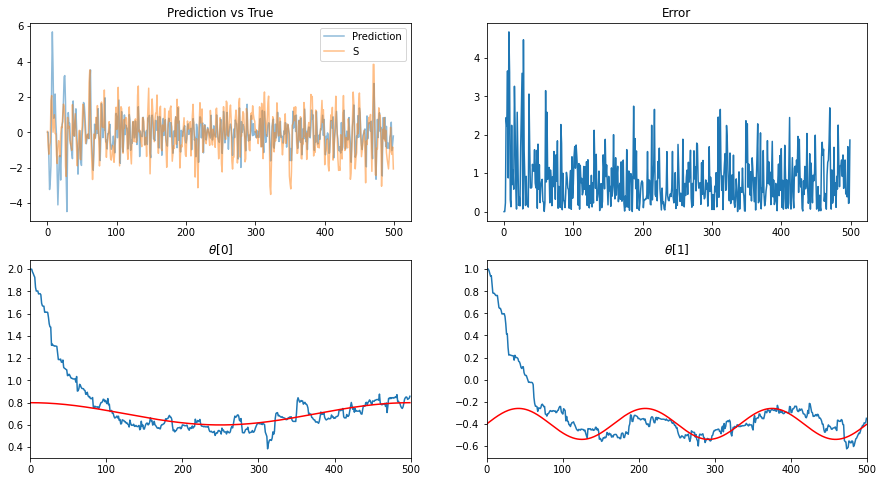

In [42]:
#initial conditions AR generation
a0 = np.array([0.7, -0.4])

stationary = False
S, a, ex = genSOAR(500, 2, a0) if stationary else genTVSOAR(500, 2, a0)

#KF parameters and initialisation
theta = np.array([2.0, 1.0])
theta = theta.reshape(-1,1)
R = 0.2*np.std(ex[0:10])
eps = 0.001
epsscale = 0.0001
kf = KalFilt(2, R, eps, epsscale, theta)

#initialise var tracking
preds = np.zeros(N)
es = np.zeros(N)
x = np.zeros((2,1))

#run KF on S
for n in range(2, N):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    preds[n] = kf.predict(x)
    es[n] = np.linalg.norm(kf.update(x, S[n]))
    
#plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
ax[0,0].plot(preds, label='Prediction',alpha=0.5)
ax[0,0].plot(S, label='S', alpha=0.5)
ax[0,0].set_title("Prediction vs True")
ax[0,0].legend()
ax[0,1].plot(es)
ax[0,1].set_title("Error")

ax[1,0].plot(kf.covLog[0])
if stationary:
    ax[1,0].axhline(a[0],color='r')
else:
    ax[1,0].plot(a[:,0],color='r')
ax[1,0].set_xlim(0,500)
ax[1,0].set_title("$\\theta$[0]")

ax[1,1].plot(kf.covLog[1])
if stationary:
    ax[1,1].axhline(a[1],color='r')
else:
    ax[1,1].plot(a[:,1],color='r')
ax[1,1].set_xlim(0,500)
ax[1,1].set_title("$\\theta$[1]")

savestr = "T-TS2.png" if stationary else "T-TV2.png"

fig.savefig(savestr)

print("Error: ", (es**2).mean(axis=0))

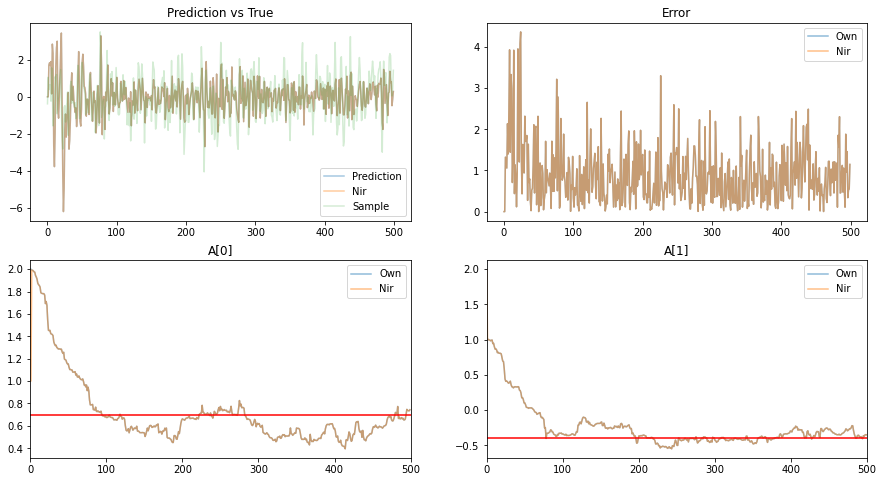

In [104]:
a0 = np.array([0.7, -0.4])
N = 500
S, a, ex = genSOAR(N, 2, a0)

theta = np.array([2.0, 1.0])
theta = theta.reshape(-1,1)
th_n1_n1 = theta.copy()

R = 0.2*np.std(ex[0:10])
eps = 0.001
epsscale =  0.0001
kf = KalFilt(2, R, eps, epsscale, theta)

#initialise var tracking
preds = np.zeros(N)
es = np.zeros(N)
x = np.zeros((2,1))

#run KF on S
for n in range(2, N):
    x[0] = S[n-1]
    x[1] = S[n-2]
    
    preds[n] = kf.predict(x)
    es[n] = np.linalg.norm(kf.update(x, S[n]))
    
# Time series data y
# th_n_n: estimate at time n using all data upto time n
# th_n_n1: estimate at time n using all data upto time n-1
#
# Initialize
#
x = np.zeros((2,1))
P_n1_n1 = 0.001*np.eye(2)
# Noise variances -- hyperparameters (to be tuned)
# Set measurement noise as fraction of data variance (first few samples)
# Guess for process noise
#
R = 0.2*np.std(ex[0:10])
beta = 0.0001
Q = beta*np.eye(2)
# Space to store and plot
#
th_conv = np.zeros([2, N])
ePlot = np.zeros(N)
yPlot = np.zeros(N)
# First two estimates are initial guesses
#
th_conv[0,0] = th_n1_n1[0]
th_conv[0,1] = th_n1_n1[1]
th_conv[1,0] = th_n1_n1[0]
th_conv[1,1] = th_n1_n1[1]
# Kalman Iteration Loop (univariate observation, start from time step 2)
#
for n in range(2, N):
# Input vector contains past velues
    x[0] = S[n-1]
    x[1] = S[n-2]
# Prediction of state and covariance
    th_n_n1 = th_n1_n1.copy()
    P_n_n1 = P_n1_n1 + Q
    yh = th_n_n1.T @ x
    en = S[n] - yh
    
    yPlot[n] = yh
    ePlot[n] = np.linalg.norm(en)
# Kalman gain (kn) and innovation variance (den)
    den = x.T @ P_n1_n1 @ x + R
    kn = P_n1_n1 @ x / den
# Posterior update
#
    th_n_n = th_n_n1 + kn * en
    P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1
# Save
    th_conv[0,n] = th_n_n[0]
    th_conv[1,n] = th_n_n[1]
# Remember for next step
#
    th_n1_n1 = th_n_n.copy()
    P_n1_n1 = P_n_n.copy()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
ax[0,0].plot(preds, label='Prediction',alpha=0.4)
ax[0,0].plot(yPlot, label='Nir',alpha=0.4)
ax[0,0].plot(S, label='Sample', alpha=0.2)
ax[0,0].set_title("Prediction vs True")
ax[0,0].legend()

ax[0,1].plot(es, label="Own", alpha=0.5)
ax[0,1].plot(ePlot, label="Nir", alpha=0.5)
ax[0,1].set_title("Error")
ax[0,1].legend()

ax[1,0].plot(kf.covLog[0], label="Own", alpha=0.5)
ax[1,0].plot(th_conv[0], label="Nir", alpha=0.5)
ax[1,0].axhline(a[0],color='r')
ax[1,0].set_xlim(0,500)
ax[1,0].set_title("A[0]")
ax[1,0].legend()

ax[1,1].plot(kf.covLog[1], label="Own", alpha=0.5)
ax[1,1].plot(th_conv[1], label="Nir", alpha=0.5)
ax[1,1].axhline(a[1],color='r')
ax[1,1].set_xlim(0,500)
ax[1,1].set_title("A[1]")
ax[1,1].legend()

fig.savefig("SampleCompare.png")

[ 0.7 -0.4]

[1.e+02 1.e+01 1.e+00 1.e-01 1.e-02]


Text(0.5, 1.0, '$\\theta$[1]')

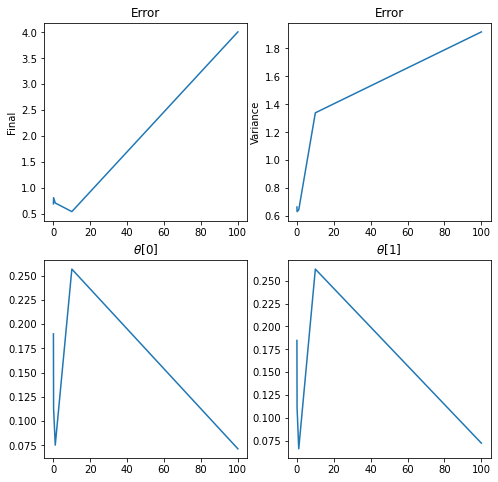

In [31]:
a0 = np.array([0.7, -0.4])
print(a0)
print()
N = 500
S, a, ex = genSOAR(N, 2, a0)

#KF parameters and initialisation
theta = np.array([2.0, 1.0])
theta = theta.reshape(-1,1)
eps = 0.001
Qeps = 0.0001
mag = 100

EPlot = np.empty(5)
VEPlot = np.empty(5)
rTrack = np.empty(5)
qTrack = np.empty(5)
covlogA0 = np.empty(5)
covlogA1 = np.empty(5)
for l in range(5):
    R = mag*np.std(ex[0:10])
    rTrack[l] = mag
    kf = KalFilt(2, R, eps, Qeps, theta)
    mag = mag/10
    
    
    #initialise var tracking
    preds = np.zeros(N)
    es = np.zeros(N)
    x = np.zeros((2,1))

    #run KF on S
    for n in range(2, N):
        x[0] = S[n-1]
        x[1] = S[n-2]
    
        preds[n] = kf.predict(x)
        es[n] = np.linalg.norm(kf.update(x, S[n]))
    EPlot[l] = es.copy()[-1]
    VEPlot[l] = np.std(es.copy())
    covlogA0[l] = np.std(kf.covLog[0].copy())
    covlogA1[l] = np.std(kf.covLog[1].copy())
    
print(rTrack)
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8,8))
ax[0, 0].plot(rTrack, EPlot)
ax[0, 0].set_title("Error")
ax[0, 0].set_ylabel("Final")

ax[0,1].plot(rTrack, VEPlot)
ax[0,1].set_title("Error")
ax[0,1].set_ylabel("Variance")

ax[1,0].plot(rTrack, covlogA0)
ax[1,0].set_title("$\\theta$[0]")

ax[1,1].plot(rTrack, covlogA1)
ax[1,1].set_title("$\\theta$[1]")
